# Bayesian Logistic Regression

This notebook is a collection of experiments with Bayesian inference.

Author: https://www.github.com/deburky

In [1]:
import pymc as pm
import numpy as np

np.random.seed(123)

# Simulate data
n = 5000
X = np.random.randn(n, 2)  # Two predictors
X = np.column_stack((np.ones(n), X))  # Add intercept
true_beta = np.array([-1, 0.5, 1])  # True coefficients
p = 1 / (1 + np.exp(-np.dot(X, true_beta)))
y = np.random.binomial(1, p)

# Bayesian Logistic Regression
with pm.Model() as logistic_model:
    # Priors for coefficients
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])

    # Likelihood
    logit_p = pm.math.dot(X, beta)
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=y)

    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True)

# Summarize posterior
pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-1.018,0.037,-1.089,-0.954,0.001,0.001,4228.0,3302.0,1.0
beta[1],0.533,0.035,0.469,0.598,0.000,0.001,5190.0,2992.0,1.0
beta[2],0.916,0.039,0.840,0.984,0.001,0.001,4484.0,2943.0,1.0


In [2]:
# Maximum likelihood logistic regression
from fisher_scoring import FisherScoringLogisticRegression
from statsmodels.api import Logit

model_sm = Logit(y, X)
result = model_sm.fit()

print(result.summary())

model_fs = FisherScoringLogisticRegression(use_bias=False)
model_fs.fit(X, y)

print(model_fs.display_summary(style="cyan1"))

Optimization terminated successfully.
         Current function value: 0.523961
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Sun, 18 May 2025   Pseudo R-squ.:                  0.1488
Time:                        17:44:21   Log-Likelihood:                -2619.8
converged:                       True   LL-Null:                       -3077.7
Covariance Type:            nonrobust   LLR p-value:                1.413e-199
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0167      0.036    -28.175      0.000      -1.087      -0.946
x1             0.5324      0.

╭── Fisher Scoring Logistic Regression Fit ──╮
│                                            │
│         Total Fisher Scoring Iterations: 6 │
│         Log Likelihood: -2619.8052         │
│         Beta 0 = intercept (bias): False   │
│                                            │
╰────────────────────────────────────────────╯

                      Fisher Scoring Logistic Regression Summary                      
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│    Beta 0 │ -1.0167  │ 0.0361     │ -28.1748       │ 0.0000  │ -1.0874  │ -0.9460  │
│    Beta 1 │ 0.5324   │ 0.0353     │ 15.0655        │ 0.0000  │ 0.4631   │ 0.6017   │
│    Beta 2 │ 0.9146   │ 0.0391     │ 23.3725        │ 0.0000  │ 0.8379   │ 0.9913   │
└───────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

None


In [3]:
import numpy as np
from rich.table import Table
from rich.console import Console

console = Console()


# Define log-posterior
def log_posterior(beta, X, y):
    log_prior = -0.5 * np.sum(beta**2)  # Gaussian prior with mean=0, sd=1
    log_likelihood = np.sum(y * X.dot(beta) - np.log(1 + np.exp(X.dot(beta))))
    return log_prior + log_likelihood


# Metropolis-Hastings
n_iter = 10_000
beta_samples = np.zeros((n_iter, X.shape[1]))
beta_current = np.zeros(X.shape[1])  # Initialize at 0
for i in range(n_iter):
    beta_proposal = beta_current + np.random.normal(0, 0.1, size=X.shape[1])  # Proposal
    log_r = log_posterior(beta_proposal, X, y) - log_posterior(beta_current, X, y)
    if np.log(np.random.rand()) < log_r:  # Accept/reject
        beta_current = beta_proposal
    beta_samples[i] = beta_current

# Create a rich table with results
table = Table(title="Metropolis-Hastings")
table.add_column("Variable", justify="right", style="cyan1")
table.add_column("\u03b8\u0302", justify="right", style="cyan1")
table.add_column("94% HDI", justify="right", style="cyan1")
table.add_column("Lower Bound", justify="right", style="cyan1")
table.add_column("Upper Bound", justify="right", style="cyan1")
for i in range(X.shape[1]):
    mean = np.mean(beta_samples[:, i])
    hdi = np.percentile(beta_samples[:, i], [2.5, 97.5])
    table.add_row(
        f"beta_{i}",
        f"{mean:.4f}",
        f"[{hdi[0]:.4f}, {hdi[1]:.4f}]",
        f"{hdi[0]:.4f}",
        f"{hdi[1]:.4f}",
    )
console.print(table)

                          Metropolis-Hastings                          
┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Variable ┃       θ̂ ┃            94% HDI ┃ Lower Bound ┃ Upper Bound ┃
┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│   beta_0 │ -1.0122 │ [-1.0839, -0.9454] │     -1.0839 │     -0.9454 │
│   beta_1 │  0.5321 │   [0.4668, 0.6006] │      0.4668 │      0.6006 │
│   beta_2 │  0.9124 │   [0.8357, 0.9869] │      0.8357 │      0.9869 │
└──────────┴─────────┴────────────────────┴─────────────┴─────────────┘

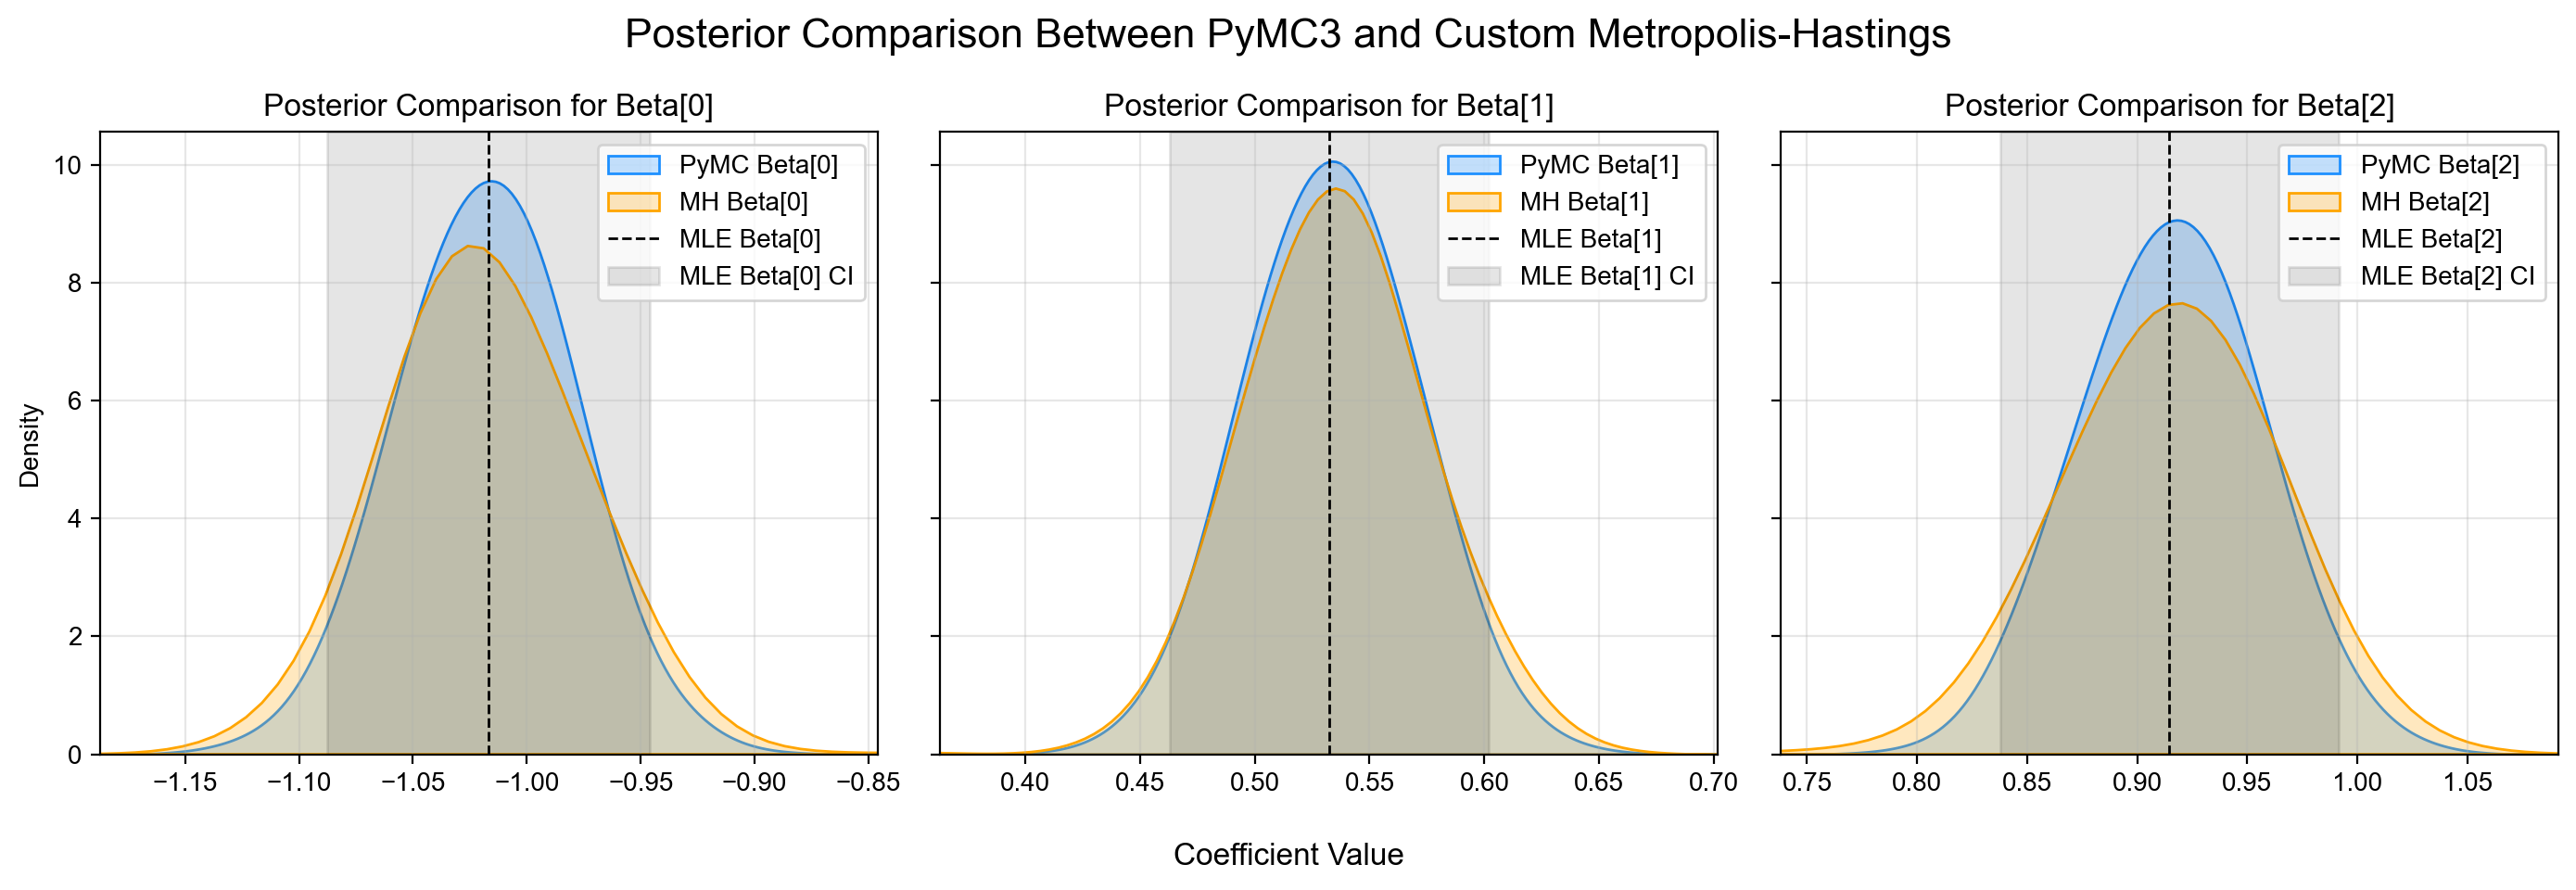

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set font to Arial
plt.rcParams["font.sans-serif"] = "Arial"

# Generate the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True, dpi=200)

# MLE estimates and confidence intervals
mle_betas = model_fs.summary()["betas"]
mle_lower_bounds = model_fs.summary()["lower_bound"]
mle_upper_bounds = model_fs.summary()["upper_bound"]

beta_pymc = trace.posterior["beta"].values
beta_pymc_0_samples = beta_pymc[:, :, 0].flatten()
beta_pymc_1_samples = beta_pymc[:, :, 1].flatten()
beta_pymc_2_samples = beta_pymc[:, :, 2].flatten()

# Custom posterior samples (transpose for iteration)
beta_custom = beta_samples.T

# Iterate over coefficients and axes
for i, (beta_p, beta_c, ax) in enumerate(
    zip(
        [beta_pymc_0_samples, beta_pymc_1_samples, beta_pymc_2_samples],
        beta_custom,
        axes,
        strict=False,
    )
):
    sns.kdeplot(
        beta_p,
        ax=ax,
        label=f"PyMC Beta[{i}]",
        color="dodgerblue",
        fill=True,
        bw_adjust=2.5,
    )
    sns.kdeplot(
        beta_c, ax=ax, label=f"MH Beta[{i}]", color="orange", fill=True, bw_adjust=2.5
    )

    # Add MLE estimate as a vertical line
    ax.axvline(
        mle_betas[i],
        color="black",
        linestyle="--",
        label=f"MLE Beta[{i}]",
        linewidth=1.0,
    )

    # Set limit to the range of the interval + some offset
    ax.set_xlim(mle_lower_bounds[i] - 0.1, mle_upper_bounds[i] + 0.1)

    # Add MLE confidence interval as a shaded region
    ax.axvspan(
        mle_lower_bounds[i],
        mle_upper_bounds[i],
        color="black",
        alpha=0.1,
        label=f"MLE Beta[{i}] CI",  # if i == 0 else None,  # Add label only once for the legend
    )
    ax.set_title(f"Posterior Comparison for Beta[{i}]")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Add common labels
fig.suptitle(
    "Posterior Comparison Between PyMC3 and Custom Metropolis-Hastings",
    fontsize=16,
    y=0.93,
)
fig.supxlabel("Coefficient Value")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit titles
plt.show()

## Credit Data

In [6]:
import pymc as pm
import numpy as np
from ISLP import load_data

# Load data
Default = load_data("Default")
features = ["balance"]
label = "default"

Default["is_student"] = Default["student"].map({"No": 0, "Yes": 1})

# Add is_student feature
X, y = Default[features], Default[label].map({"No": 0, "Yes": 1})

# Prepare data
X = Default[features].values
y = Default[label].map({"No": 0, "Yes": 1}).values

# Bayesian Logistic Regression
with pm.Model() as logistic_model:
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    logit_p = pm.math.dot(X, beta)
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=y)
    trace = pm.sample(1000, return_inferencedata=True)

# Summarize posterior
pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
INFO:pymc.sampling.mcmc:NUTS: [beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.003,0.0,-0.003,-0.003,0.0,0.0,1622.0,2401.0,1.0


In [17]:
import pandas as pd

pd.DataFrame(
    trace.posterior["beta"].values.reshape(-1, X.shape[1]), columns=features
).describe()

,balance
count,4000.000000
mean,0.066552
std,0.120177
min,-0.003060
25%,-0.002847
50%,-0.002801
75%,0.066678
max,0.274679


## Binomial Regression

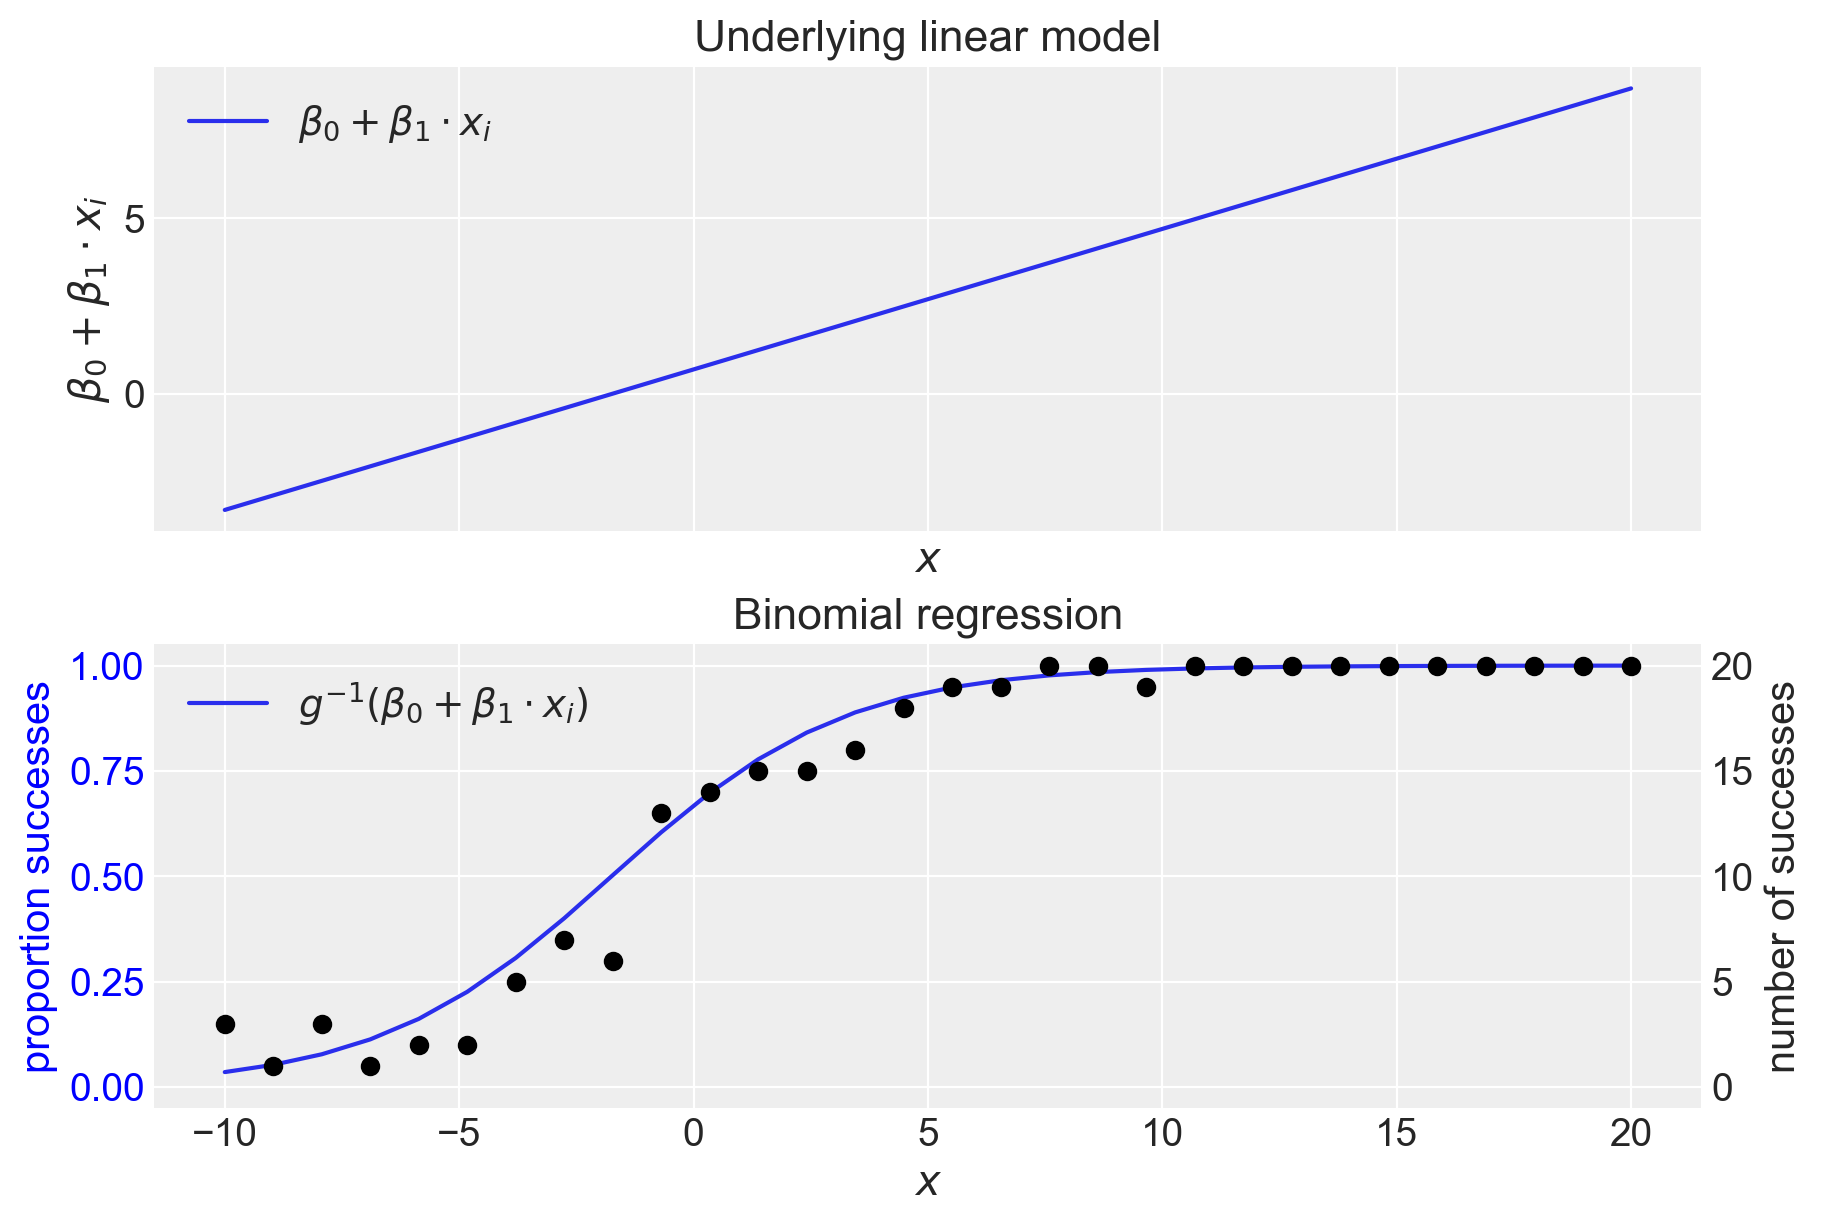

In [18]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})

# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x, mu_true, label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(
    xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model"
)
ax[0].legend()

# Plot GLM
freq = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
freq.set_ylabel("number of successes")
freq.scatter(x, y, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x, p_true, label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")
ax[1].set_ylabel("proportion successes", color="b")
ax[1].tick_params(axis="y", labelcolor="b")
ax[1].set(xlabel="$x$", title="Binomial regression")
ax[1].legend()
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)

In [19]:
coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.ConstantData("x", data["x"], dims="observation")
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

/Users/deburky/Documents/python/python-ml-projects/.venv/lib/python3.11/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [20]:
with binomial_regression_model:
    idata = pm.sample(1000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]
INFO:pymc.sampling.mcmc:NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

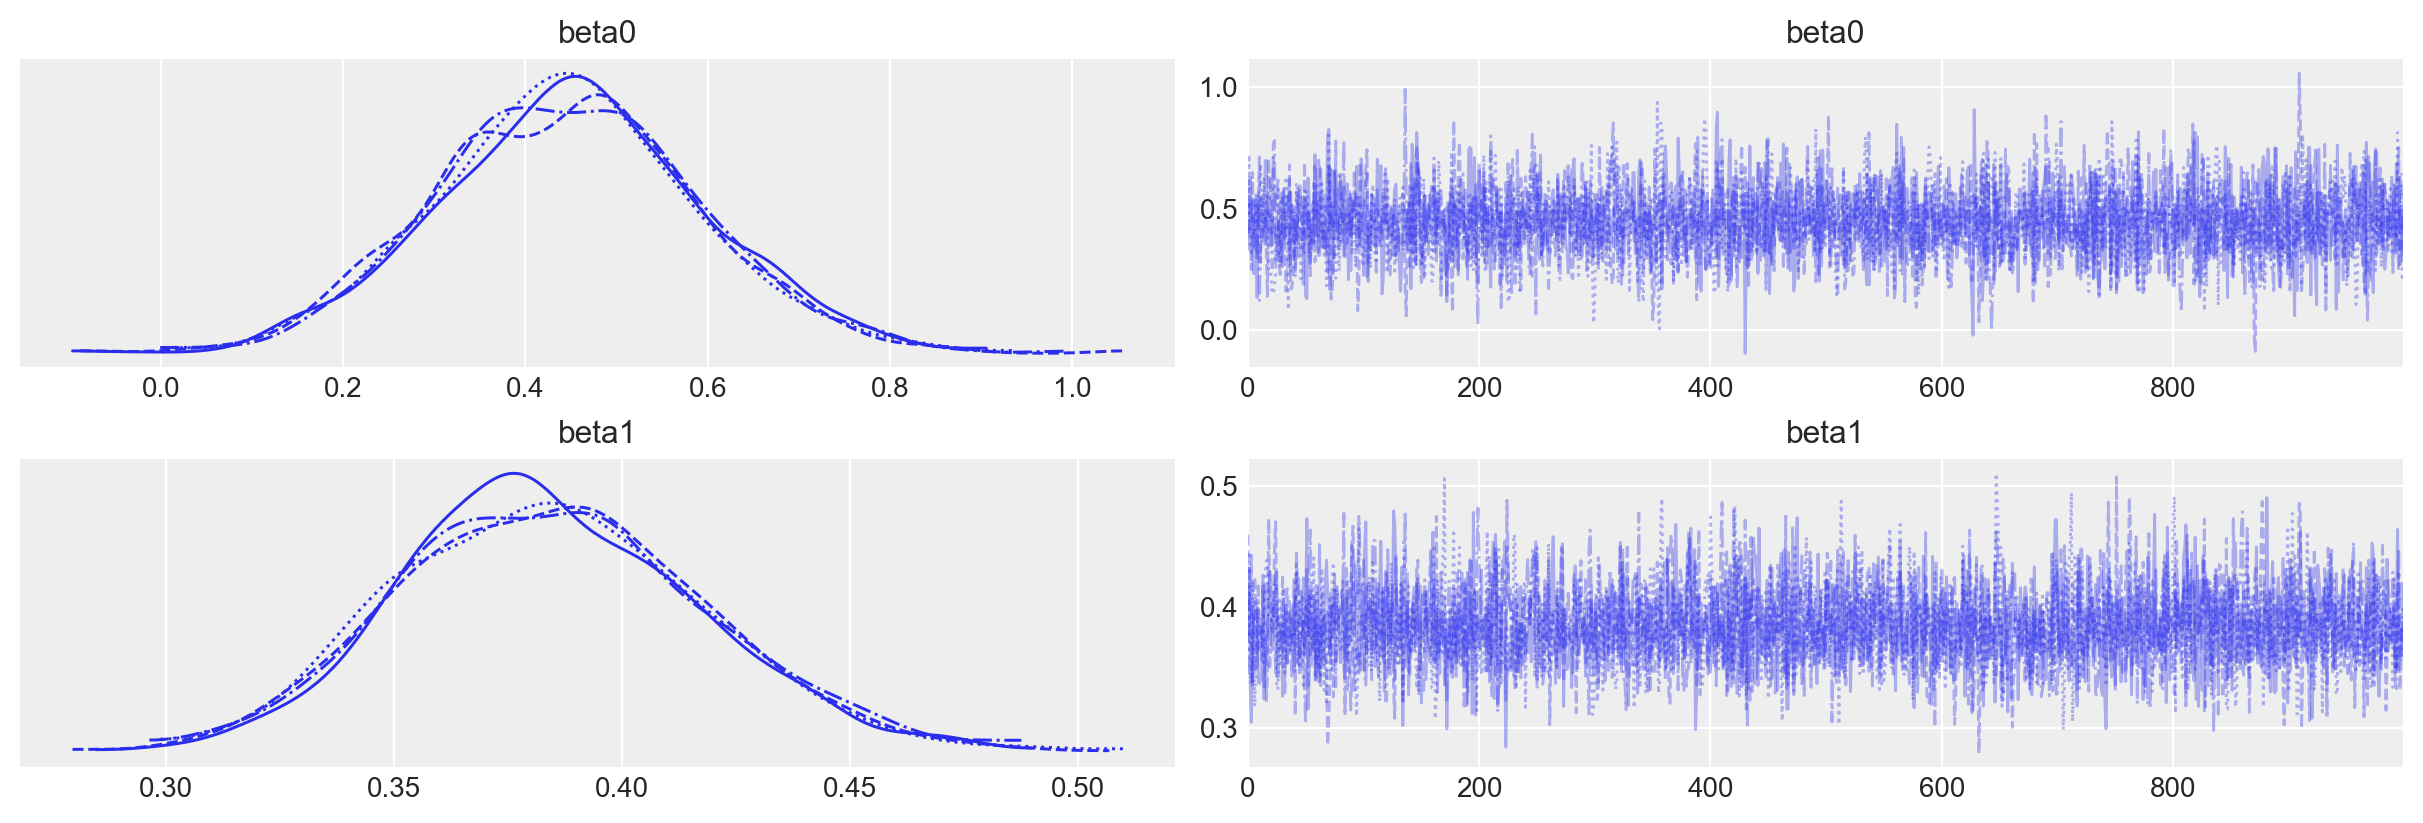

In [21]:
az.plot_trace(idata, var_names=["beta0", "beta1"])

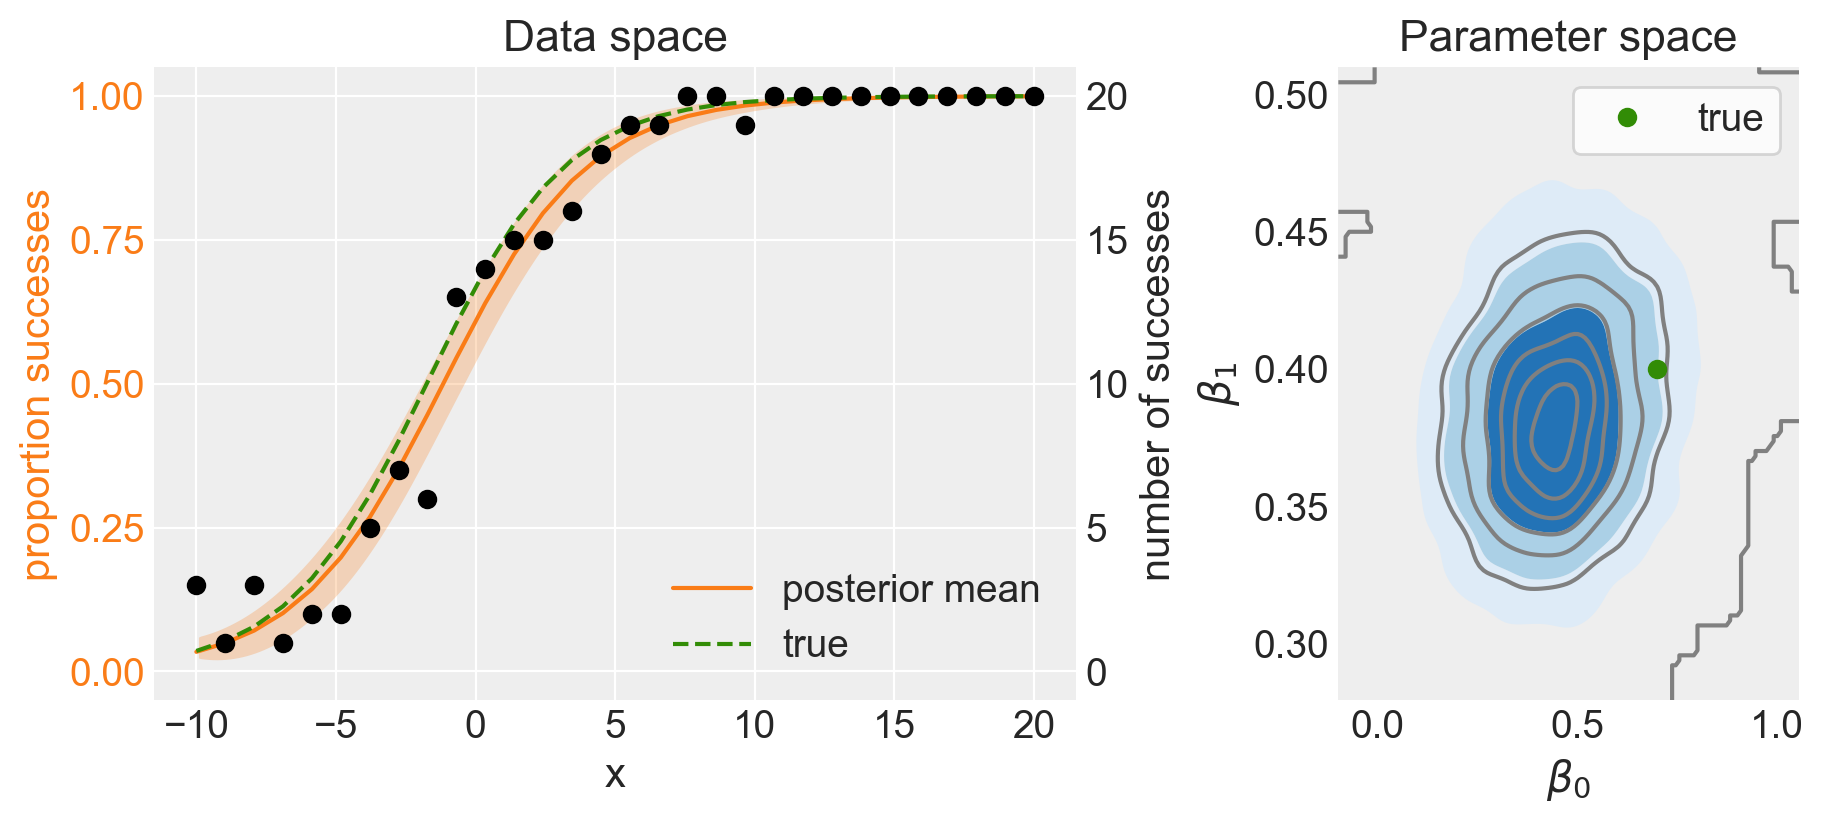

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True)

## Binomial Logistic Regression

We can turn Bernoulli data into binomial data treating X as discrete values each containing a number of successes.

In [23]:
from ISLP import load_data

# Load data
Default = load_data("Default")

# Encode categorical variables
Default["is_student"] = Default["student"].map({"No": 0, "Yes": 1})
Default["default"] = Default["default"].map({"No": 0, "Yes": 1}).astype(int)

X = Default["balance"].values
y = Default["default"].values

# Convert Bernoulli Data to Binomial Format
binomial_data = Default.groupby("balance", as_index=False).agg(  # Group by balance
    trials=("default", "count"),  # Total number of observations per balance
    successes=("default", "sum"),
)  # Number of successful defaults

binomial_data["success_rate"] = binomial_data["successes"] / binomial_data["trials"]

# Extract values for modeling
X_bin = binomial_data["balance"].values
trials = binomial_data["trials"].values
successes = binomial_data["successes"].values
y_binomial = binomial_data["success_rate"].values

binomial_data.sample(5)

,balance,trials,successes,success_rate
2709,591.498014,1,0,0.0
2606,575.768345,1,0,0.0
7025,1168.895545,1,0,0.0
5378,935.693635,1,0,0.0
648,218.639297,1,0,0.0


In [26]:
# Fit Bayesian Binomial Logistic Regression
import pymc as pm

# Bayesian Binomial Regression
with pm.Model() as binomial_model:
    beta = pm.Normal("beta", mu=0, sigma=10)  # Prior on slope
    alpha = pm.Normal("alpha", mu=0, sigma=10)  # Prior on intercept

    # Logit transformation
    logit_p = alpha + beta * X_bin
    p = pm.math.invlogit(logit_p)

    # Binomial likelihood
    y_obs = pm.Binomial("y_obs", n=trials, p=p, observed=successes)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Summarize posterior
summary = pm.summary(trace)
print(summary)

Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
INFO:pymc.sampling.mcmc:NUTS: [beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta    0.006  0.000   0.005    0.006      0.000    0.000    1495.0    1240.0   
alpha -10.673  0.356 -11.325  -10.004      0.009    0.008    1502.0    1261.0   

       r_hat  
beta     1.0  
alpha    1.0  


In [27]:
from sklearn.linear_model import LogisticRegression
from fisher_scoring import FisherScoringLogisticRegression

# Fit logistic regression
model = LogisticRegression()
model.fit(X_bin.reshape(-1, 1), successes)

# Display results
print(f"Intercept: {model.intercept_[0]:.4f}")
print(f"Balance Coefficient: {model.coef_[0][0]:.4f}")

model_fs = FisherScoringLogisticRegression()
model_fs.fit(X_bin.reshape(-1, 1), successes)

print(model_fs.display_summary(style="cyan1"))

Intercept: -10.6498
Balance Coefficient: 0.0055


╭── Fisher Scoring Logistic Regression Fit ───╮
│                                             │
│         Total Fisher Scoring Iterations: 10 │
│         Log Likelihood: -798.2140           │
│         Beta 0 = intercept (bias): True     │
│                                             │
╰─────────────────────────────────────────────╯

                      Fisher Scoring Logistic Regression Summary                      
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│    Beta 0 │ -10.6498 │ 0.3614     │ -29.4707       │ 0.0000  │ -11.3581 │ -9.9415  │
│    Beta 1 │ 0.0055   │ 0.0002     │ 24.9345        │ 0.0000  │ 0.0051   │ 0.0059   │
└───────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

None


In [28]:
from sklearn.linear_model import LogisticRegression

# Fit logistic regression
model = LogisticRegression()
model.fit(X.reshape(-1, 1), y)

# Display results
print(f"Intercept: {model.intercept_[0]:.4f}")
print(f"Balance Coefficient: {model.coef_[0][0]:.4f}")

model_fs = FisherScoringLogisticRegression(use_bias=True)
model_fs.fit(X.reshape(-1, 1), y)

print(model_fs.display_summary(style="cyan1"))

Intercept: -10.6513
Balance Coefficient: 0.0055


╭── Fisher Scoring Logistic Regression Fit ───╮
│                                             │
│         Total Fisher Scoring Iterations: 10 │
│         Log Likelihood: -798.2258           │
│         Beta 0 = intercept (bias): True     │
│                                             │
╰─────────────────────────────────────────────╯

                      Fisher Scoring Logistic Regression Summary                      
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Parameter ┃ Estimate ┃ Std. Error ┃ Wald Statistic ┃ P-value ┃ Lower CI ┃ Upper CI ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│    Beta 0 │ -10.6513 │ 0.3612     │ -29.4913       │ 0.0000  │ -11.3592 │ -9.9435  │
│    Beta 1 │ 0.0055   │ 0.0002     │ 24.9524        │ 0.0000  │ 0.0051   │ 0.0059   │
└───────────┴──────────┴────────────┴────────────────┴─────────┴──────────┴──────────┘

None
